In [60]:
import math
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy import stats, integrate
import pandas as pd
import pytz
import datetime as dt

import biosppy
from biosppy import storage
from biosppy.signals import ecg


# misc
import warnings

import seaborn as sns

## Read and manipulate psychopy and shimmer files 

In [54]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df
    

## Time Domain HRV

In [55]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [128]:

#psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv"
#ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_6B1E_Calibrated_SD.csv"

psychopy_file_path = "D:/Datasets/data_sony_digiRelax/study/VP006_091123/Psychopy_data/VP006_091123_DigiRelax_Experiment_2023-11-09_10h17.40.415.csv"
ecg_file_path ="D:/Datasets/data_sony_digiRelax/study/VP006_091123/Shimmer_data/2023-11-09_08.37.26_VP006_091123_SD_Session1/VP006_091123_Session1_Shimmer_6B1E_Calibrated_SD.csv" 



event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts", "saliva_probe_4_ts", "saliva_probe_4_ts"]

#selected events
event_interest = event_interest_list_new[3]

#ä offset time in mins
time_offset = 5

sampling_freq = 256

nr_plots = 6

psychopy start time: 2023-11-09 10:53:15.930165+01:00
psychopy stop time: 2023-11-09 10:58:15.930165+01:00
ECG start time: 2023-11-09 10:53:15.933533+01:00
ECG stop time: 2023-11-09 10:58:15.929626+01:00


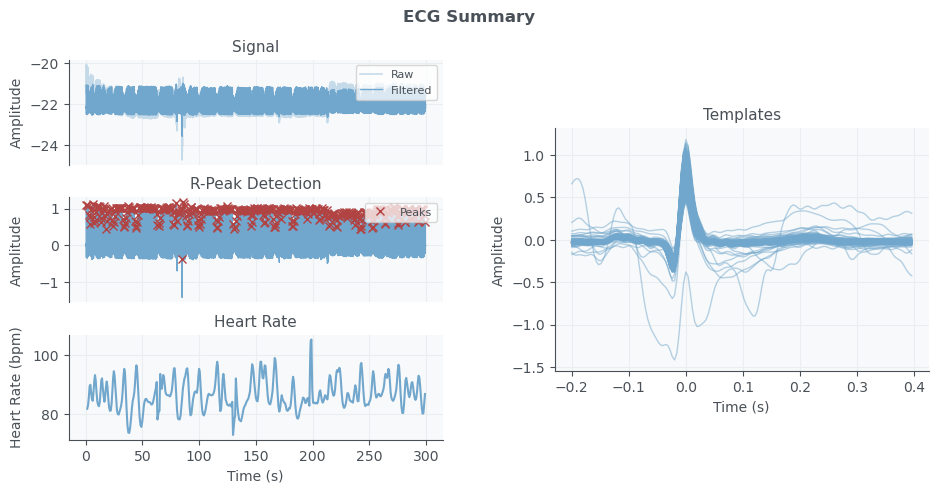

0
12800
12800
25600
25600
38400
38400
51200
51200
64000
64000
76800


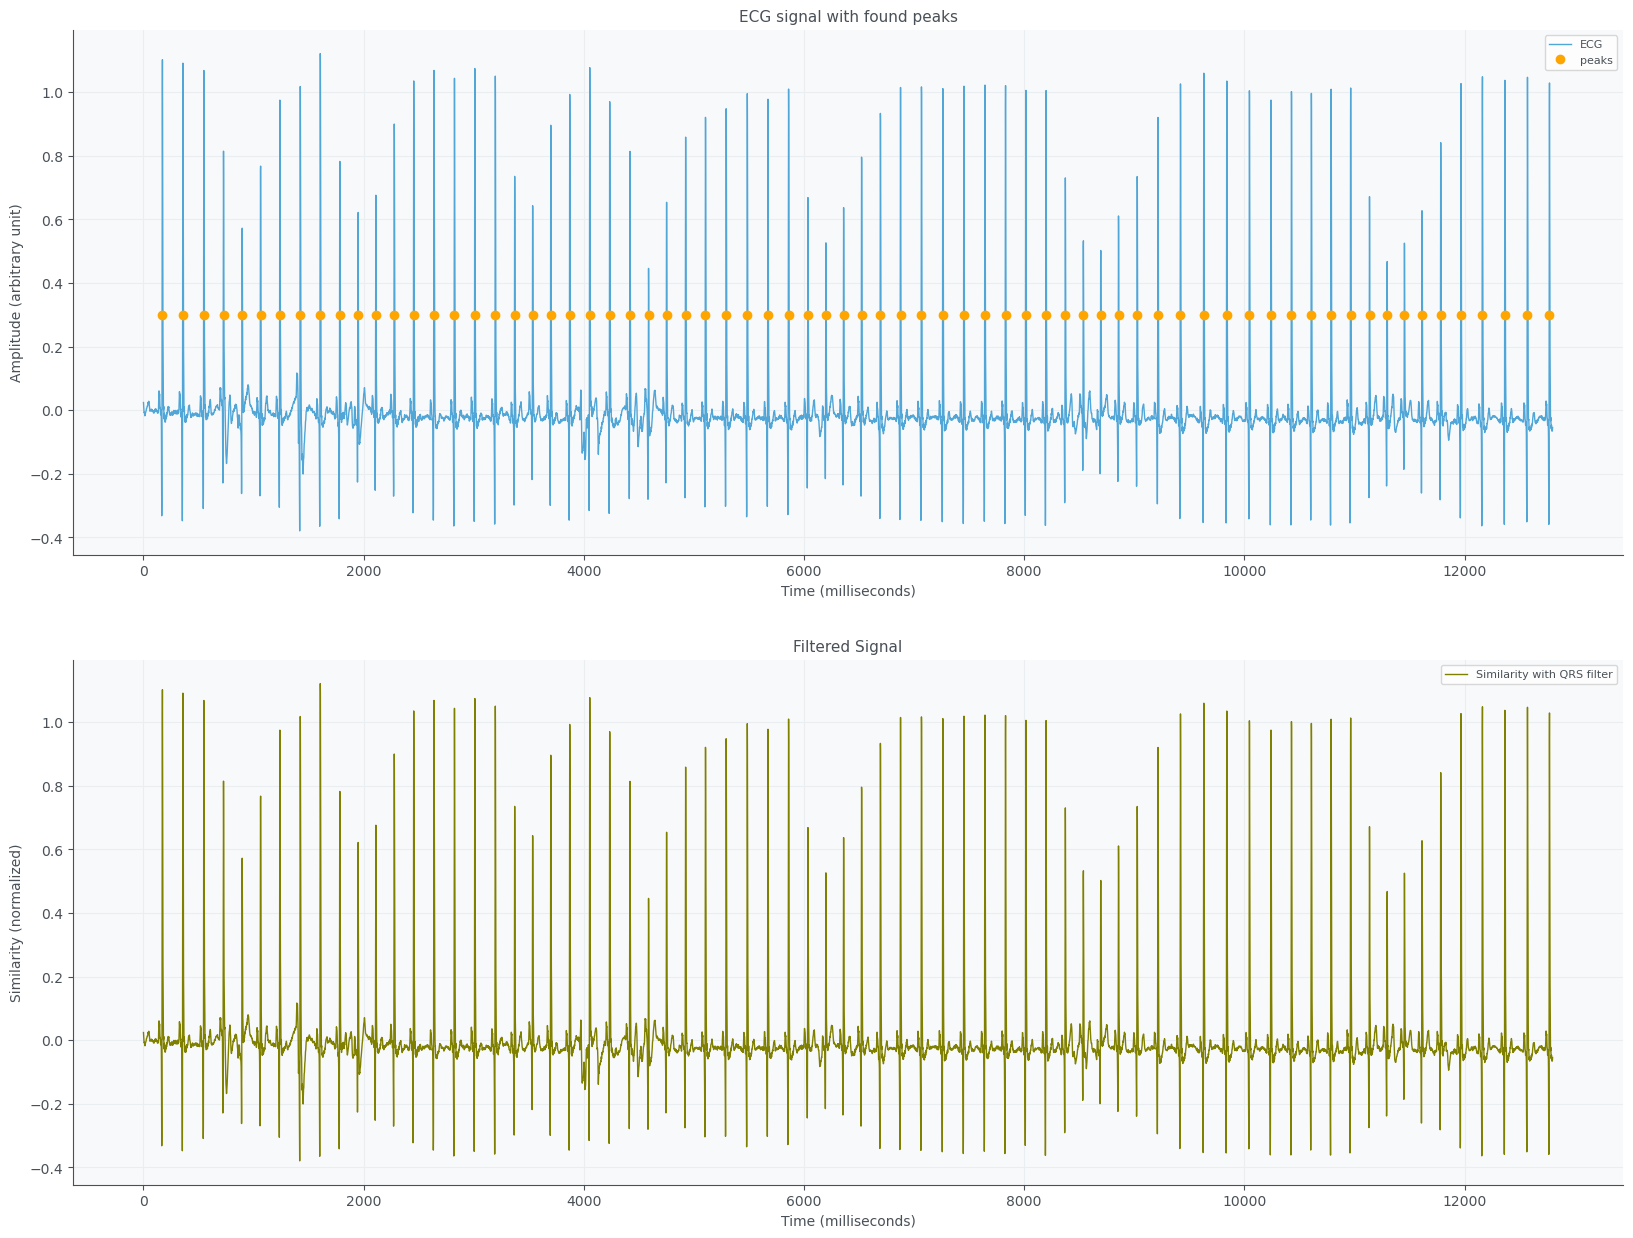

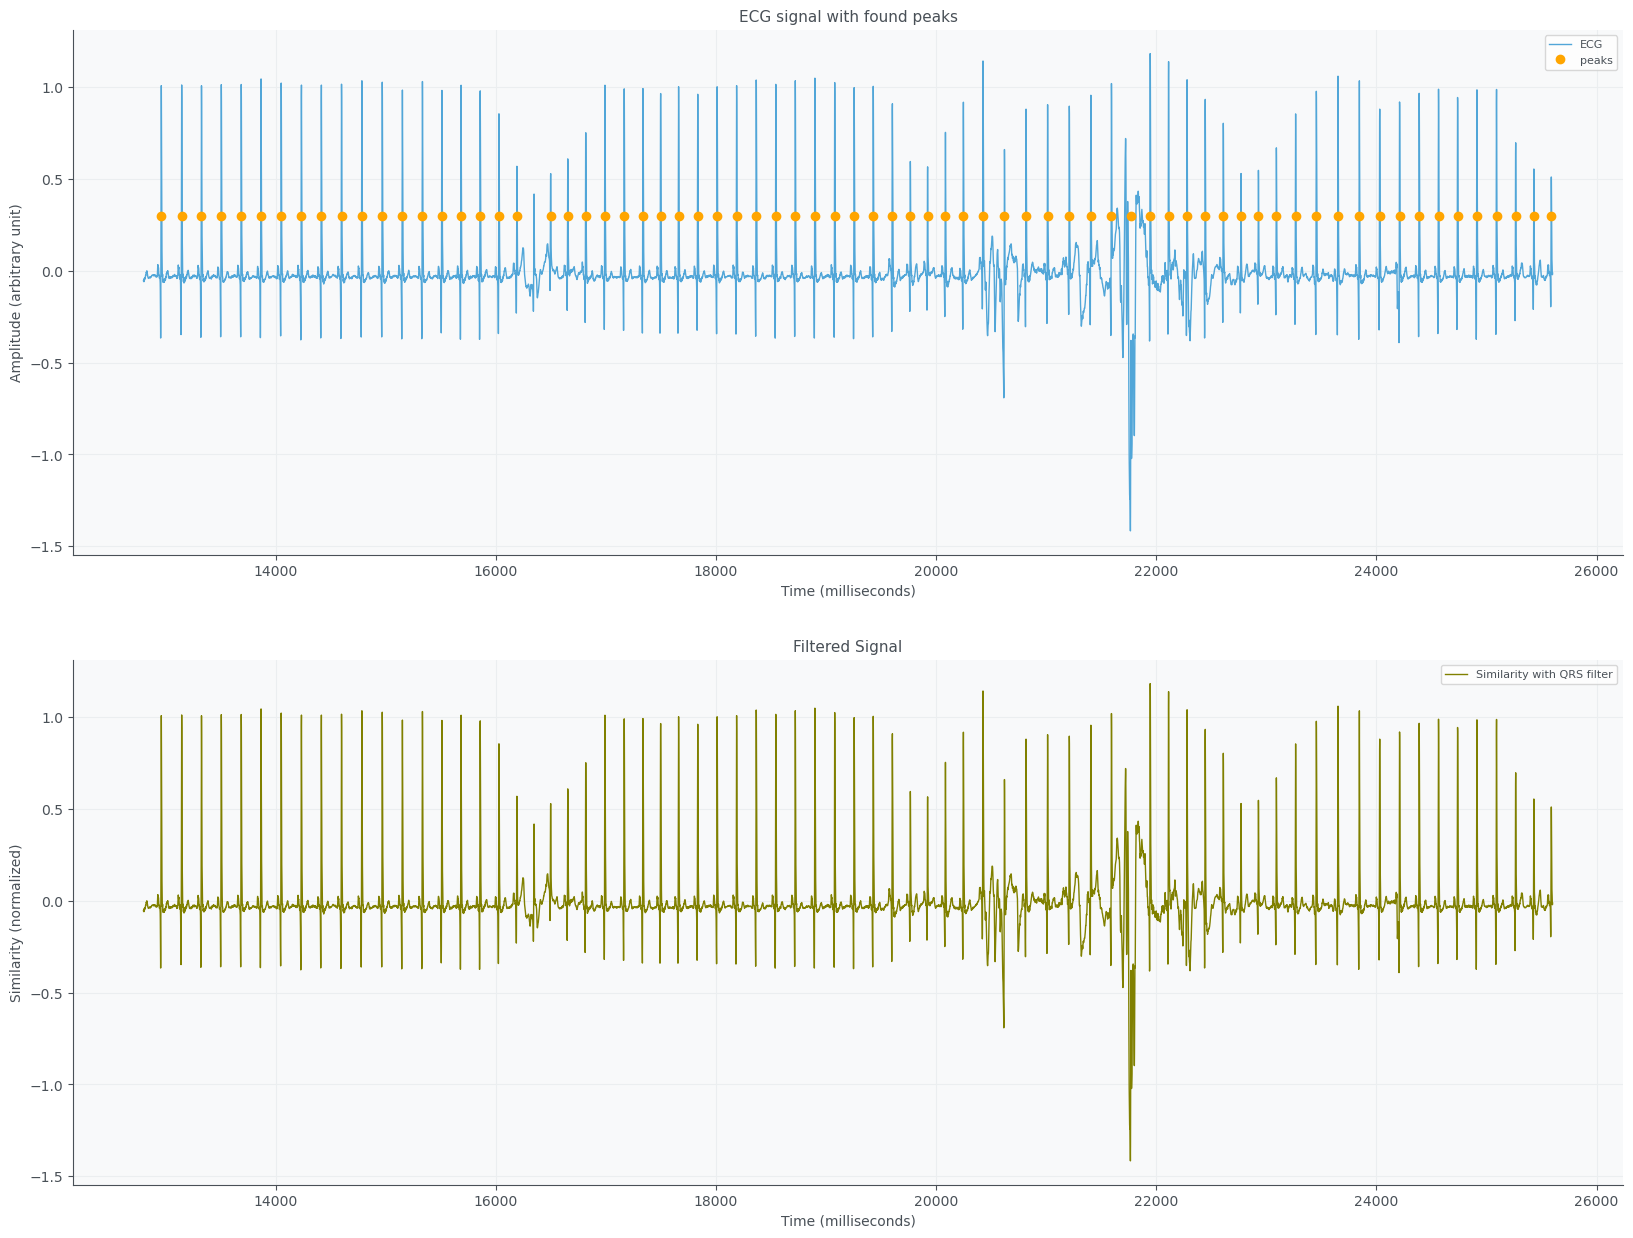

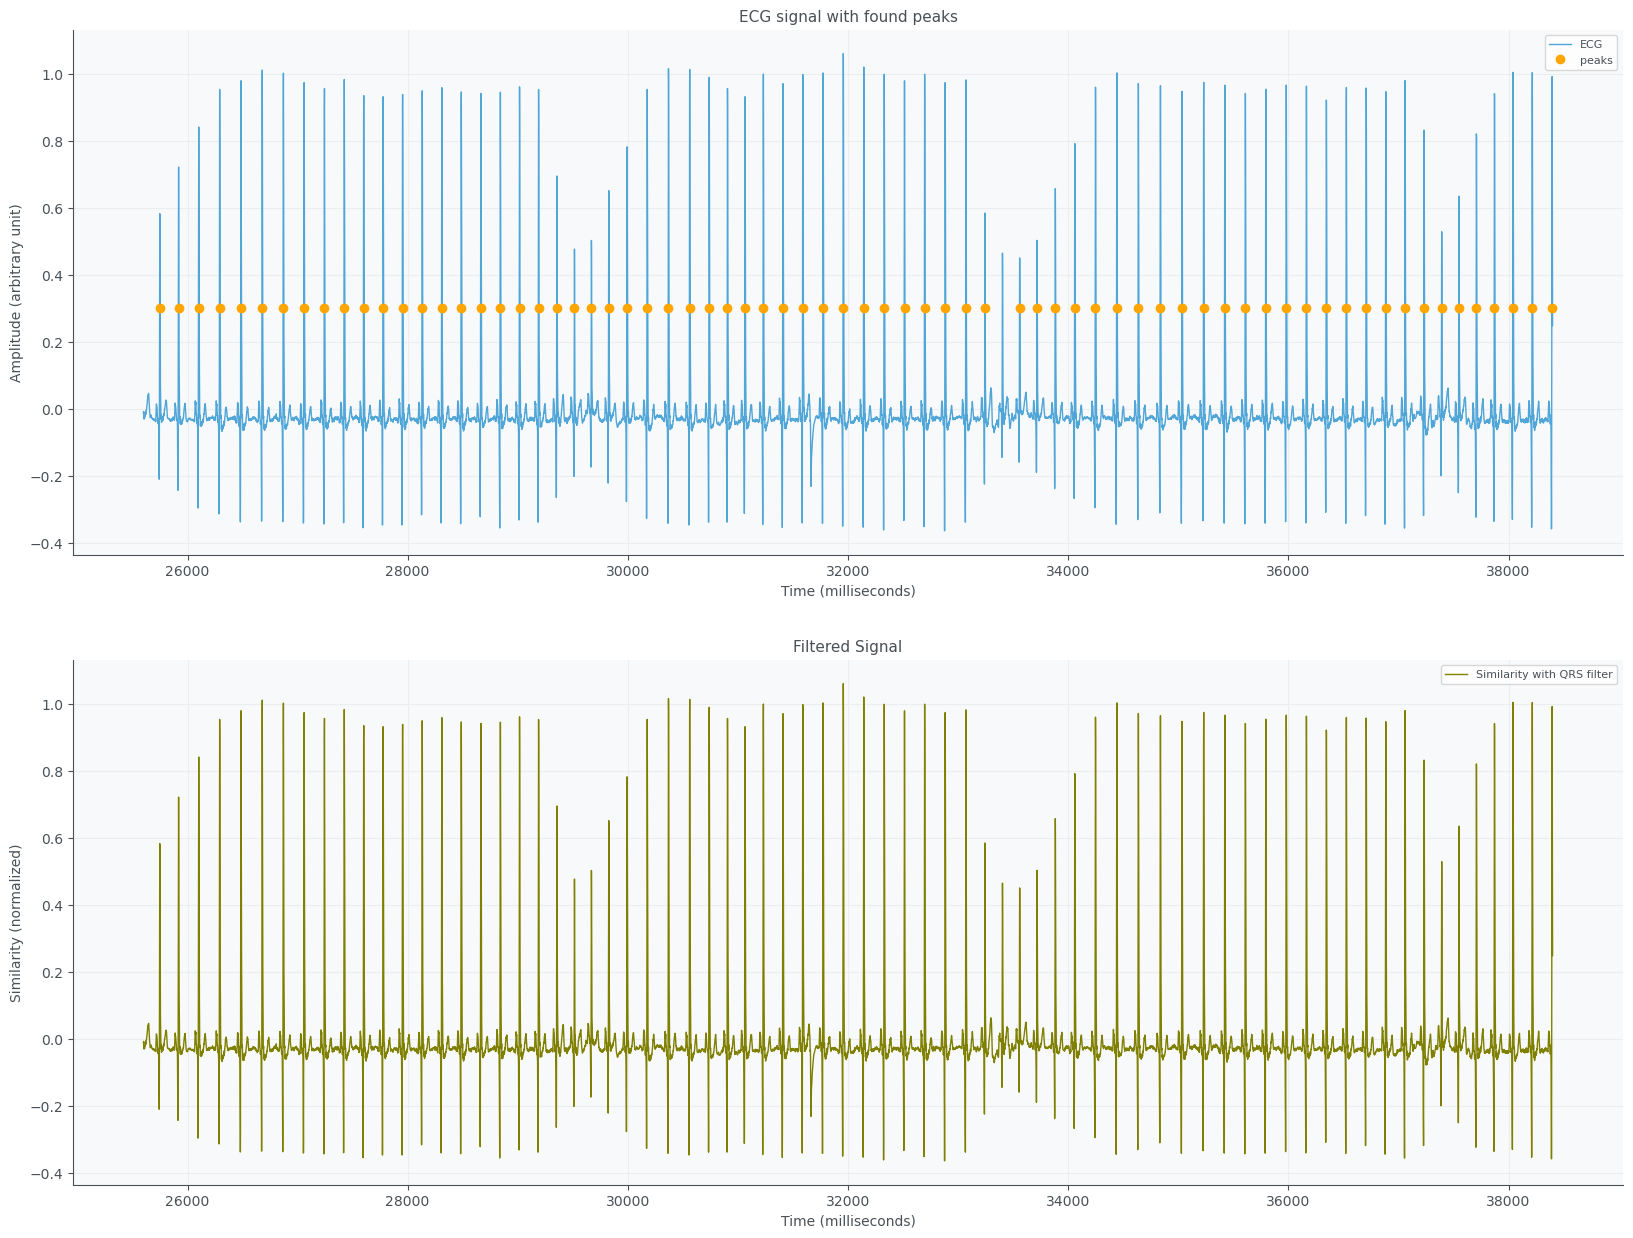

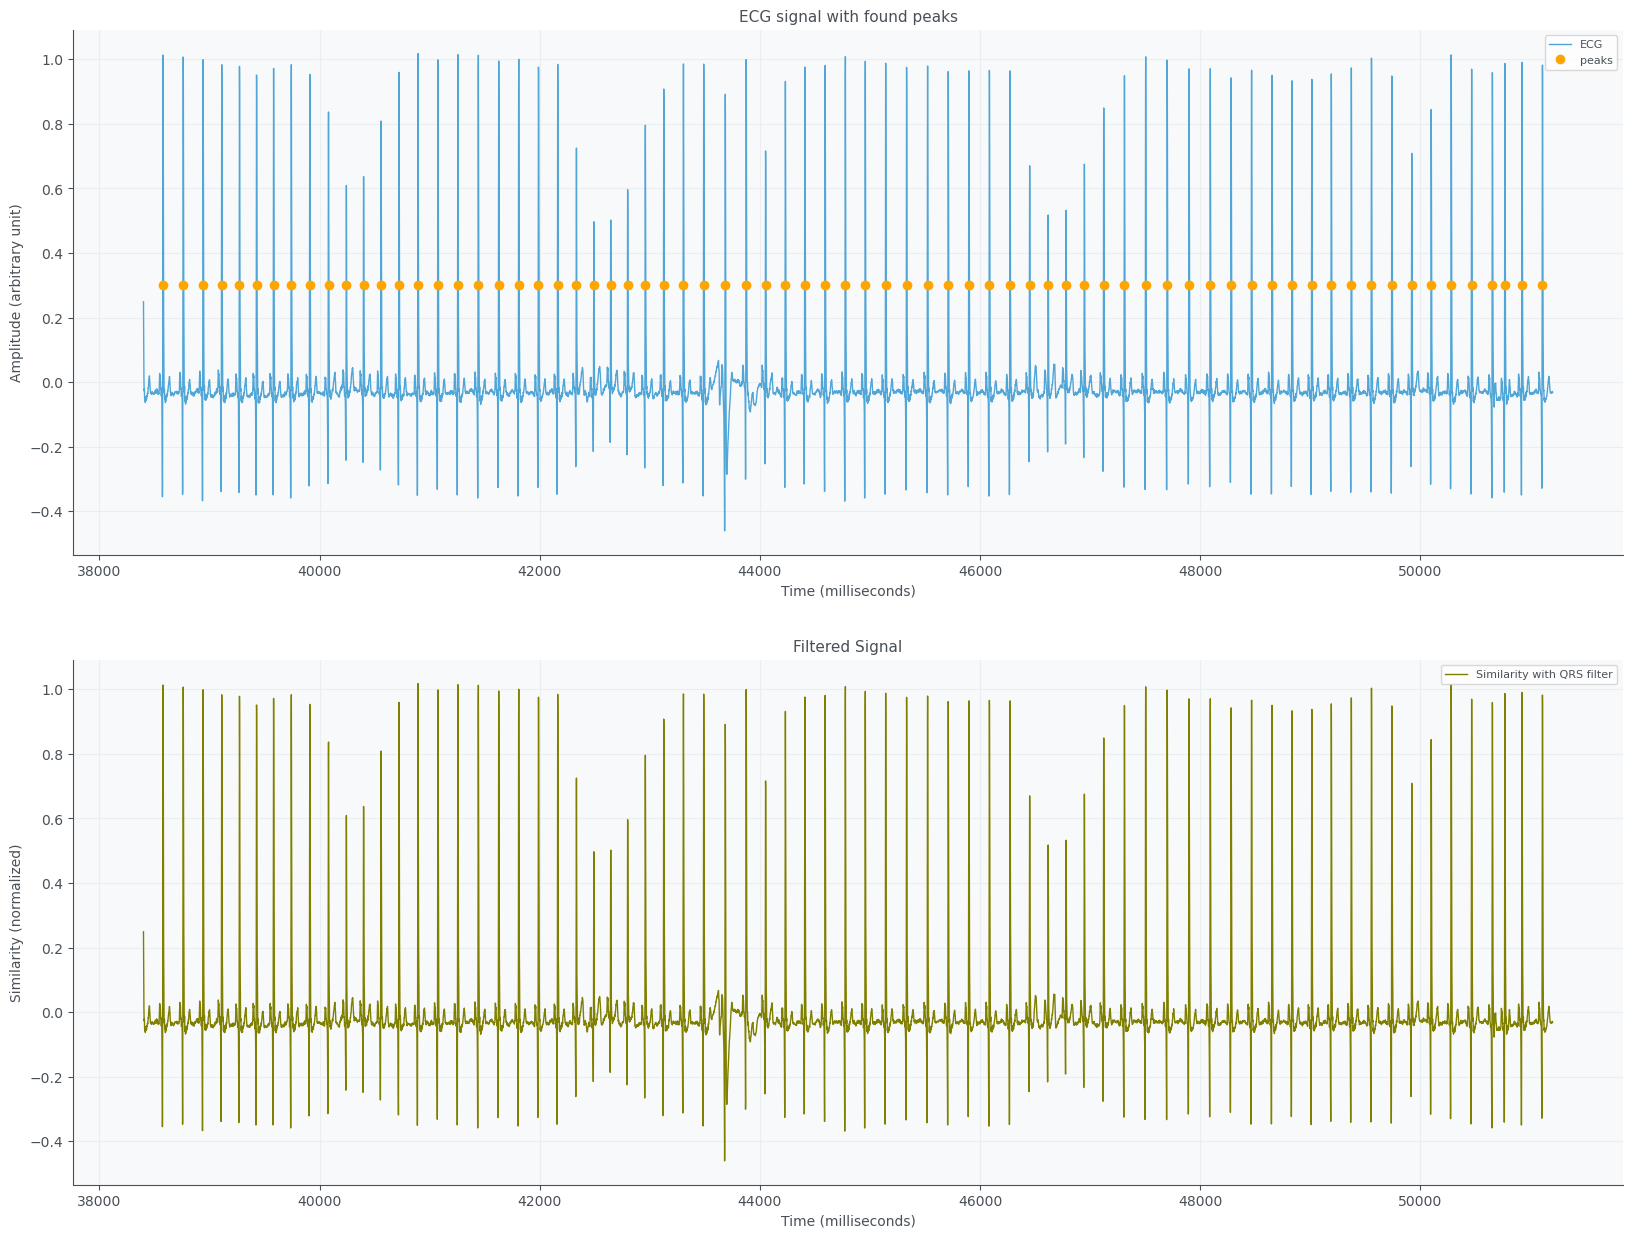

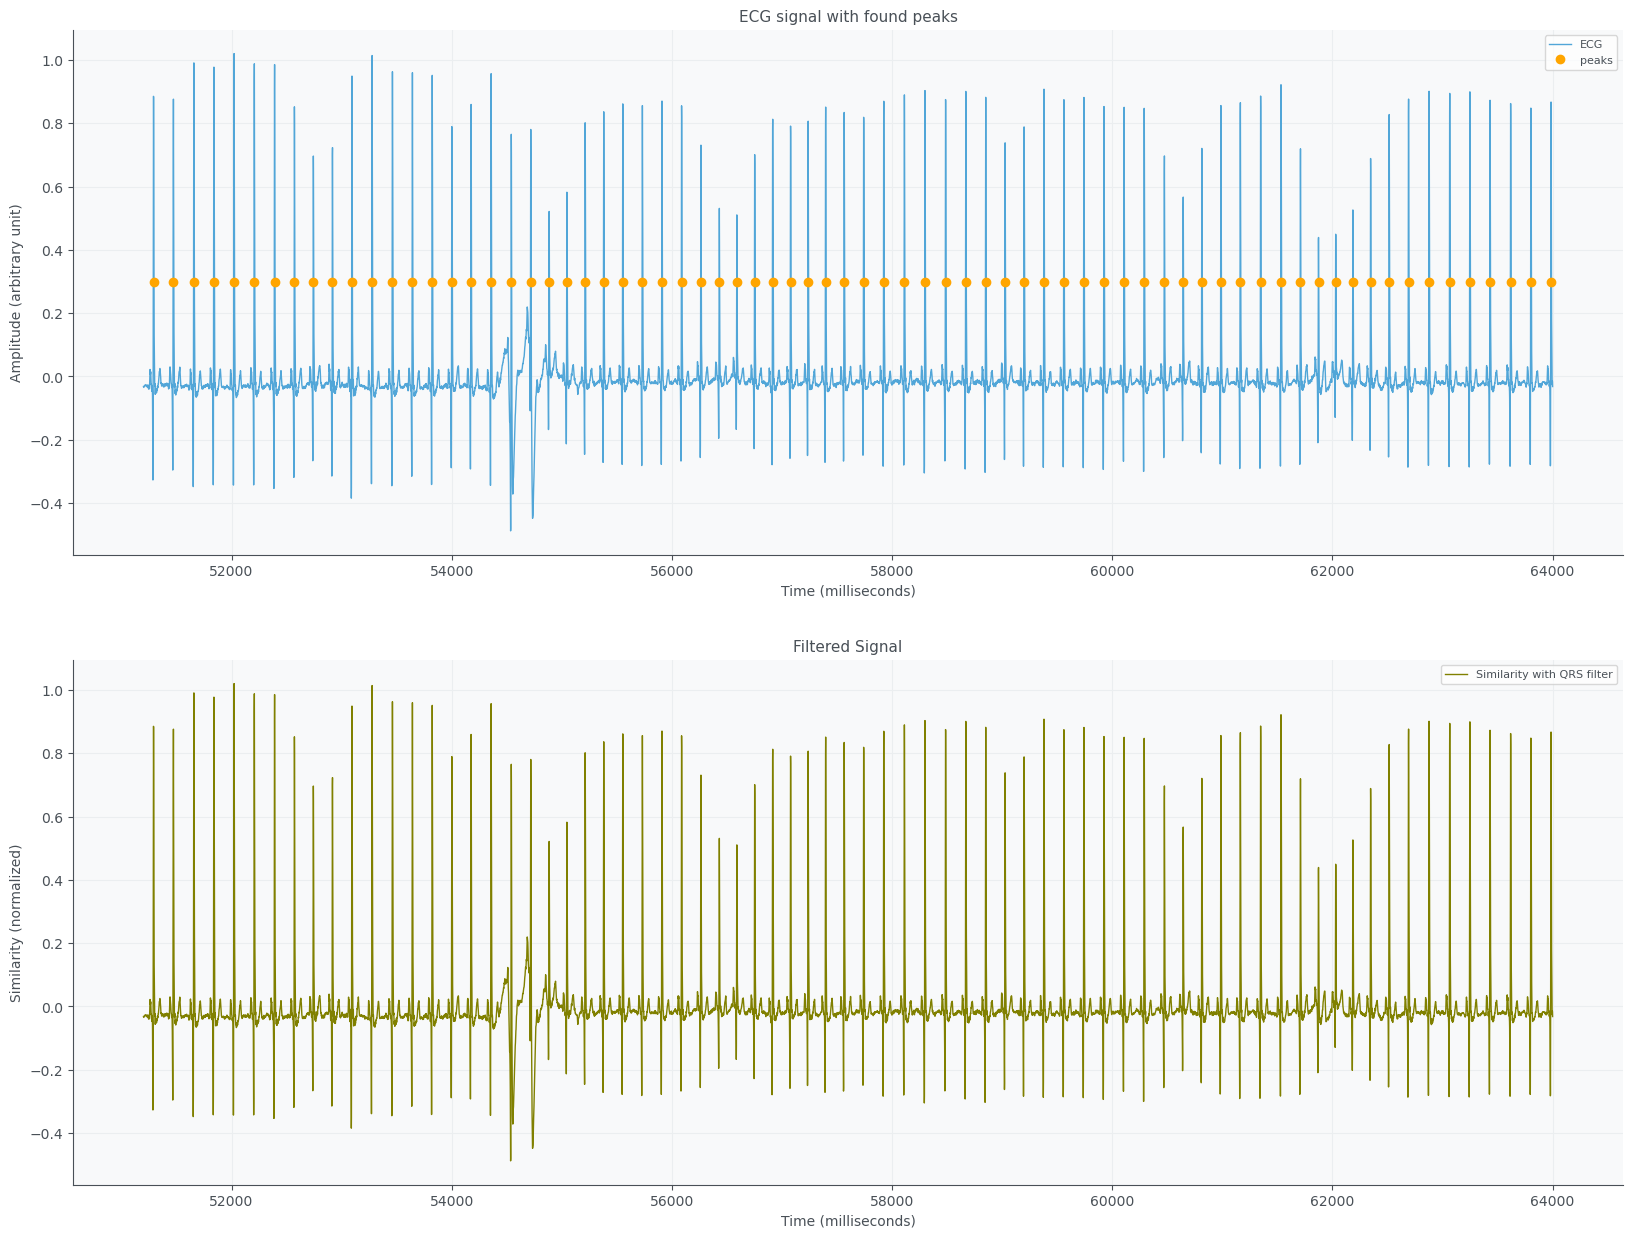

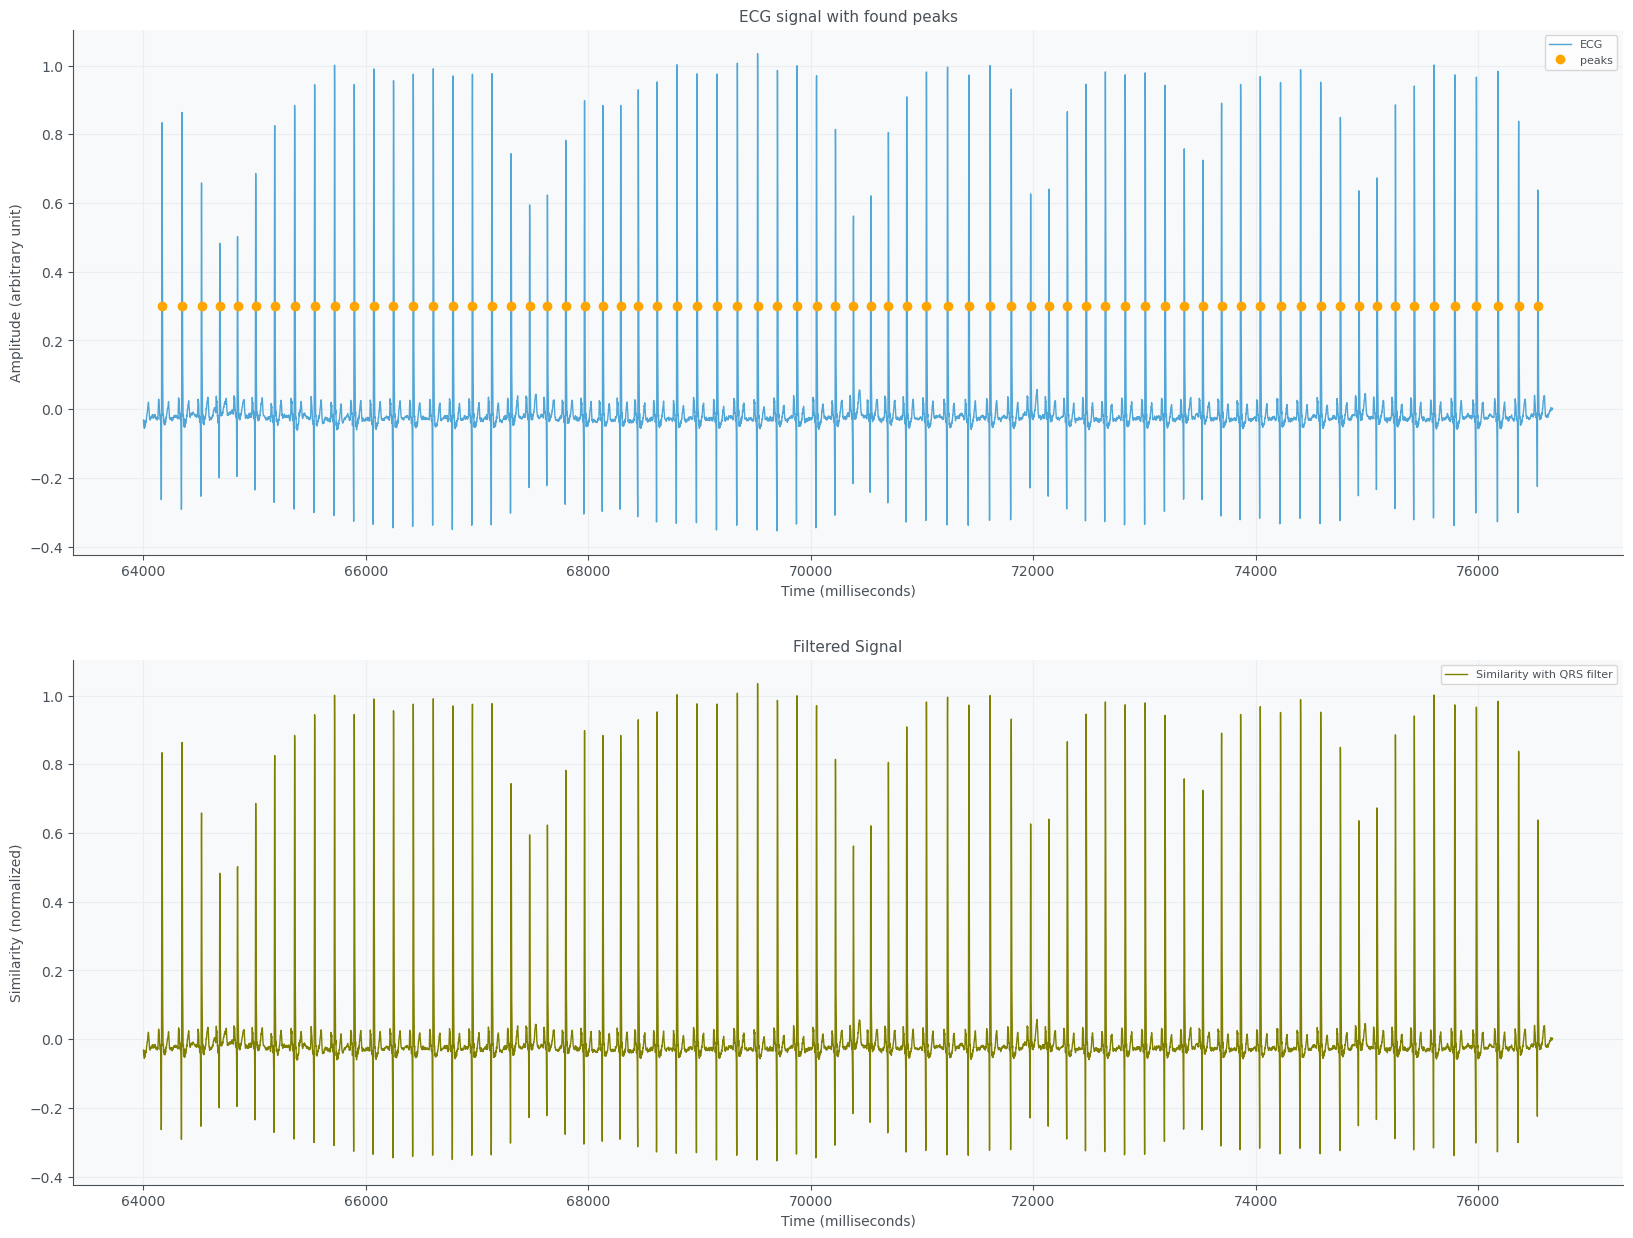

In [129]:

ecg_col_name = "Shimmer_6B1E_ECG_LA-RA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"


psychopy_df = read_manipulate_psychopy(psychopy_file_path)
non_nan_timestamp=get_nonNan_list_psychopy(psychopy_df, event_interest)

start_timestamp = non_nan_timestamp[0]
stop_timestamp = get_offset_timestamp(start_timestamp, time_offset)


#print("psychopy start timestamp: " + str(start_timestamp))
#print("psychopy stop timestamp: " + str(stop_timestamp))

time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)
    
start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
end_time  = dt.datetime.fromtimestamp(stop_timestamp, tz)

print("psychopy start time: "+str(start_time))
print("psychopy stop time: "+str(end_time))

###---------ECG------------------------------------
ecg_df = read_shimmer_sensor(ecg_file_path)

selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)


sliced_ecg_df=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp, stop_timestamp, timestamp_shimmer_col_name)
sliced_ecg_df=sliced_ecg_df.reset_index(drop=True)

start_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[0]
stop_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[-1]

start_time_hr = dt.datetime.fromtimestamp(start_time_hr, tz)
end_time_hr  = dt.datetime.fromtimestamp(stop_time_hr, tz)

print("ECG start time: " + str(start_time_hr))
print("ECG stop time: " + str(end_time_hr))

sliced_ecg_df=sliced_ecg_df.copy()
sliced_ecg_df['heartrate'] = sliced_ecg_df[ecg_col_name]
sliced_ecg_df=col_from_str_float (sliced_ecg_df, "heartrate")

ecg_array = sliced_ecg_df["heartrate"].values

out = ecg.ecg(signal=ecg_array, sampling_rate=sampling_freq, show=True,interactive=False)

sliced_ecg_df["filtered"] = out["filtered"]
r_peaks = out["rpeaks"]

starting_index_slcide_df= sliced_ecg_df.index[0]
sampfrom = starting_index_slcide_df
sampto = starting_index_slcide_df+256*time_offset*60

#rr_interval_cumm = []
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    print(start)
    print(stop)
    # get sliced data of ECG
    cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index <= stop)
    sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]
    r_peaks_selected = [r_p for r_p in r_peaks if r_p >= start and r_p <= stop]

    # detect peaks
    
    #peaks, similarity = detect_peaks(sliced_ecg_hrv, threshold=0.3)
    
    # plot similarity
    
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(r_peaks_selected, np.repeat(0.3, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Filtered Signal')
    #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.plot(sliced_ecg_hrv, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

In [130]:
# RR-intervals are the differences between successive peaks
rr = np.diff(r_peaks)
heart_rate = out["heart_rate"]
#rr=r_peaks

In [131]:
print("mean_rr: "+ str(np.mean(rr)*1/sampling_freq))
print("std_rr: " + str(np.std(rr)*1/sampling_freq))
print("mean_heart_rate: " + str(np.mean(heart_rate)))
print("std_heart_rate: " + str(np.std(heart_rate)))

mean_rr: 0.6937318313953489
std_rr: 0.05682204890097172
mean_heart_rate: 86.9922208502911
std_heart_rate: 5.118741248503504


<Figure size 640x480 with 0 Axes>

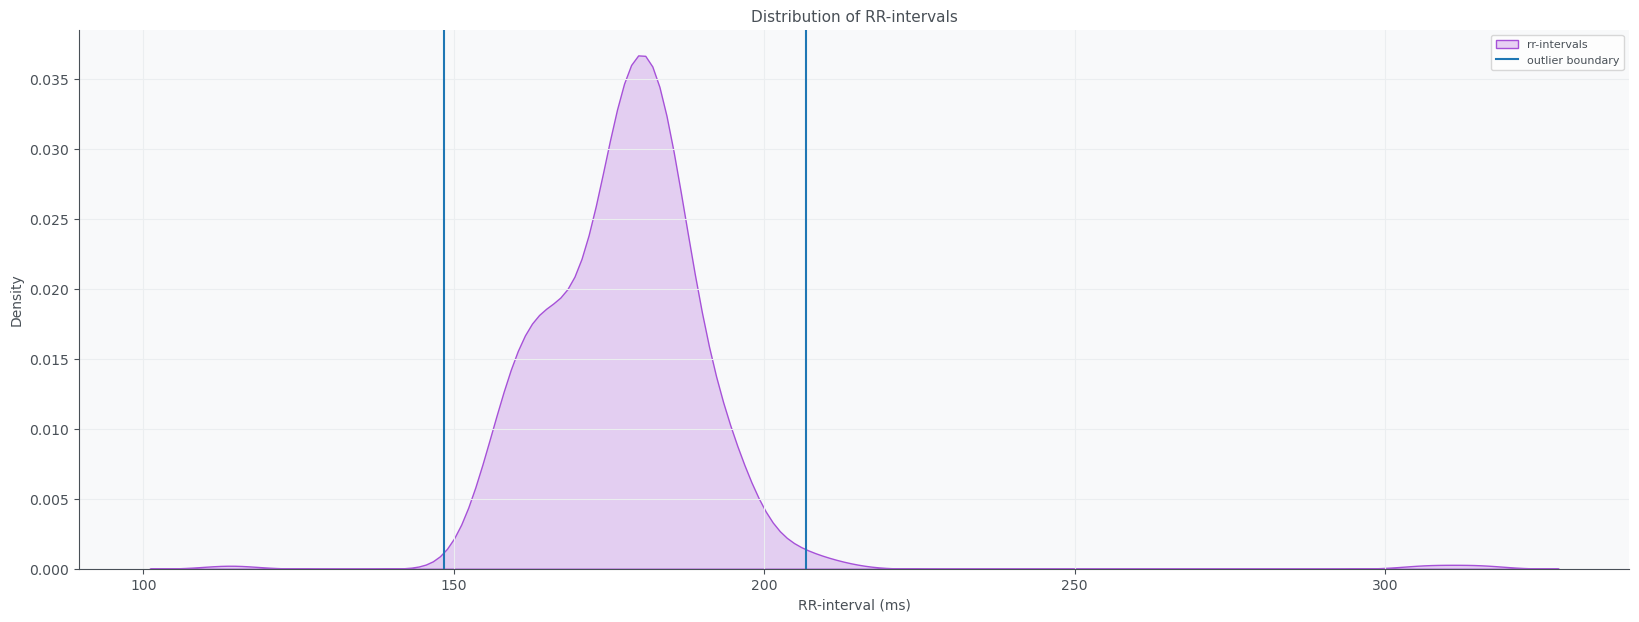

In [132]:
plt.figure()
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)
    
    
outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)
plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
#plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
#plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

In [133]:
#out

ReturnTuple(ts=array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
       2.99484375e+02, 2.99488281e+02, 2.99492188e+02]), filtered=array([0.02441619, 0.01948345, 0.01327298, ..., 0.00267611, 0.00303549,
       0.0027078 ]), rpeaks=array([  172,   358,   549,   727,   896,  1064,  1239,  1424,  1606,
        1784,  1950,  2111,  2278,  2455,  2639,  2825,  3010,  3196,
        3372,  3535,  3700,  3872,  4054,  4235,  4419,  4588,  4752,
        4925,  5105,  5293,  5485,  5673,  5860,  6036,  6199,  6360,
        6523,  6694,  6877,  7067,  7261,  7453,  7644,  7831,  8016,
        8199,  8374,  8538,  8696,  8857,  9027,  9216,  9420,  9632,
        9841, 10046, 10242, 10428, 10609, 10788, 10966, 11137, 11298,
       11454, 11614, 11784, 11968, 12163, 12367, 12572, 12772, 12962,
       13147, 13327, 13507, 13688, 13868, 14051, 14235, 14416, 14599,
       14784, 14969, 15152, 15334, 15511, 15685, 15859, 16029, 16192,
       16499, 16654, 16817, 16992, 17167, 17337, 17498, 176

In [127]:
heart_rate

array([112.11678832, 111.84597482, 112.39963798, 113.5236158 ,
       114.34809245, 114.34809245, 112.95330113, 111.59880377,
       109.98493458, 109.45491388, 109.98493458, 110.50741022,
       110.77051402, 110.77051402, 111.86190758, 113.5236158 ,
       114.91840713, 115.78035999, 116.97404187, 118.47780127,
       119.37984496, 118.47780127, 117.26568006, 115.5016835 ,
       114.92275994, 114.63112175, 114.91415105, 114.91415105,
       114.62686567, 114.34383637, 113.78193997, 114.65695422,
       115.51890708, 116.08080348, 113.56826258, 111.09244053,
       108.93982334, 108.93982334, 109.72921587, 110.24430642,
       108.98322267, 105.78905817, 102.03814242,  99.13286088,
        97.6306394 ,  99.17254269, 102.5716752 , 109.5512273 ,
       113.68505179, 116.96482545, 116.36808886, 115.79777418,
       114.92275994, 113.78193997, 113.50307287, 112.94117647,
       112.66638042, 112.94524752, 113.50714392, 114.34383637,
       114.34383637, 114.06080708, 114.63973064, 117.02